# Data Prep - BTC Supply, Pricing, On-Chain & Techincal Indicators, and Sentiment Scores

In [29]:
# Import libraries and dependencies
import pandas as pd
import numpy as np
from pathlib import Path
import datetime as dt
import json
import requests
import matplotlib.pyplot as plt
#import hvplot.pandas
import os
from dotenv import load_dotenv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)

## Load & Prep: BTC Price, Volume & Supply Data

In [30]:
#Load BTC Price & Volume Data from CoinMarketCap
csv_path_btc_price = Path('../crypto_bot_project_2/Data/BTC-USD.csv')
btc_price_df = pd.read_csv(csv_path_btc_price)
btc_price_df['Date'] = pd.to_datetime(btc_price_df['Date']).dt.date
btc_price_df = btc_price_df.set_index('Date')
btc_price_df.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2021-03-21,58309.91,58767.90,56005.62,57523.42,5.194341e+10,1.073417e+12
2021-03-20,58332.26,60031.29,58213.30,58313.64,5.036173e+10,1.088105e+12
2021-03-19,57850.44,59498.38,56643.70,58346.65,4.906387e+10,1.088666e+12
2021-03-18,58893.08,60116.25,54253.58,57858.92,5.574604e+10,1.079511e+12
2021-03-17,56825.83,58969.82,54528.63,58870.89,6.025831e+10,1.098338e+12


In [31]:
#Load BTC Supply Data
response_data = requests.get('https://api.blockchain.info/charts/total-bitcoins?timespan=10years&format=json')

btc_supply_df = pd.read_json(response_data.text)
btc_supply_df = btc_supply_df['values'].apply(pd.Series)
btc_supply_df = btc_supply_df.rename(columns = {'x': 'Date', 'y': 'Circulating Supply'})
btc_supply_df['Date'] = pd.to_datetime(btc_supply_df['Date'], unit='s').dt.date
btc_supply_df = btc_supply_df.set_index('Date')
btc_supply_df.head()

,Circulating Supply
Date,
2011-03-26,5753550.0
2011-03-28,5771850.0
2011-03-30,5790100.0
2011-04-01,5808700.0
2011-04-03,5827250.0


In [32]:
#Join BTC Supply & Price/Volume into single DataFrame
btc_df = btc_supply_df.join(btc_price_df, how = 'outer')

#Backfill Supply Column to Daily Grain where null
btc_df['Circulating Supply'] = btc_df['Circulating Supply'].ffill()
btc_df.head()

,Circulating Supply,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,,
2011-03-26,5753550.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-03-28,5771850.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-03-30,5790100.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-04-01,5808700.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-04-03,5827250.0,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
#Slice BTC_DF is appropiate date range for both supply and price data sets
start_date = dt.date(2013, 4, 29)
btc_df = btc_df.loc[start_date:]
btc_df.head()

#Add BTC Max Supply and Circulating Supply Ratio
btc_df['Max Supply'] = 21000000
btc_df['Supply Ratio'] = (btc_df['Circulating Supply'] / btc_df['Max Supply']) * 100

#Volume over Circulating Supply Ratio
btc_df['Volume Supply Ratio'] = (btc_df['Volume'] / btc_df['Circulating Supply'])

#Volume over Closing Price Ratio
btc_df['Volume Close Ratio'] = (btc_df['Volume'] / btc_df['Close'])

#MarketCap over CLosing Price Ratio
btc_df['MarketCap Close Ratio'] = (btc_df['Market Cap'] / btc_df['Close'])

#MarketCap over Circulating Supply Ratio
btc_df['MarketCap Supply Ratio'] = (btc_df['Market Cap'] / btc_df['Circulating Supply'])

btc_df.head()

,Circulating Supply,Open,High,Low,Close,Volume,Market Cap,Max Supply,Supply Ratio,Volume Supply Ratio,Volume Close Ratio,MarketCap Close Ratio,MarketCap Supply Ratio
Date,,,,,,,,,,,,,
2013-04-29,11089225.0,134.44,147.49,134.00,144.54,0.0,1.603769e+09,21000000,52.805833,0.0,0.0,1.109568e+07,144.624071
2013-04-30,11098425.0,144.00,146.93,134.05,139.00,0.0,1.542813e+09,21000000,52.849643,0.0,0.0,1.109938e+07,139.011898
2013-05-01,11098425.0,139.00,139.89,107.72,116.99,0.0,1.298955e+09,21000000,52.849643,0.0,0.0,1.110313e+07,117.039543
2013-05-02,11098425.0,116.38,125.60,92.28,105.21,0.0,1.168517e+09,21000000,52.849643,0.0,0.0,1.110652e+07,105.286786
2013-05-03,11107625.0,106.25,108.13,79.10,97.75,0.0,1.085995e+09,21000000,52.893452,0.0,0.0,1.110993e+07,97.770241


In [34]:
trading_days = 5

# Calculate the portfolio daily returns
btc_df["Daily Returns"] = btc_df["Close"].pct_change()

# Calculate the cumulative returns
btc_df["Cumulative Returns"] = (
    1 + btc_df["Daily Returns"]
).cumprod() - 1


# Calculate 5 trading days return
btc_df['Window Return'] = (
    btc_df['Daily Returns'].rolling(window = trading_days).mean() * trading_days
)

# Calculate 5 trading days volatility
btc_df['Window Volatility'] = (
    btc_df['Daily Returns'].rolling(window = trading_days).std() * np.sqrt(trading_days)
)

# Calculate Sharpe Ratio
btc_df['Sharpe Ratio'] = (
    btc_df['Daily Returns'].rolling(window = trading_days).mean() * trading_days) / (
    btc_df['Daily Returns'].rolling(window = trading_days).std() * np.sqrt(trading_days)
)

# Calculate Downside Return
sortino_ratio_df = btc_df[['Daily Returns']]
sortino_ratio_df.loc[:,'Downside Returns'] = 0
#sortino_ratio_df.head()

target = 0
mask = sortino_ratio_df['Daily Returns'] < target
sortino_ratio_df.loc[mask, 'Downside Returns'] = sortino_ratio_df['Daily Returns']**2

# Calculate Sortino Ratio
down_stdev = np.sqrt(sortino_ratio_df['Downside Returns'].rolling(window = trading_days).mean()) * np.sqrt(trading_days)
expected_return = sortino_ratio_df['Daily Returns'].rolling(window = trading_days).mean() * trading_days
sortino_ratio = expected_return/down_stdev

btc_df['Sortino Ratio'] = sortino_ratio
btc_df.tail()

,Circulating Supply,Open,High,Low,Close,Volume,Market Cap,Max Supply,Supply Ratio,Volume Supply Ratio,Volume Close Ratio,MarketCap Close Ratio,MarketCap Supply Ratio,Daily Returns,Cumulative Returns,Window Return,Window Volatility,Sharpe Ratio,Sortino Ratio
Date,,,,,,,,,,,,,,,,,,,
2021-03-17,18655268.75,56825.83,58969.82,54528.63,58870.89,6.025831e+10,1.098338e+12,21000000,88.834613,3230.096226,1.023567e+06,1.865672e+07,58875.466767,0.036370,406.298257,0.031703,0.113550,0.279196,0.484484
2021-03-18,18657550.00,58893.08,60116.25,54253.58,57858.92,5.574604e+10,1.079511e+12,21000000,88.845476,2987.854300,9.634822e+05,1.865764e+07,57859.209108,-0.017190,399.296942,-0.053703,0.083525,-0.642958,-0.793765
2021-03-19,18657550.00,57850.44,59498.38,56643.70,58346.65,4.906387e+10,1.088666e+12,21000000,88.845476,2629.706140,8.409030e+05,1.865859e+07,58349.914686,0.008430,402.671302,-0.013584,0.080529,-0.168687,-0.227251
2021-03-20,18657550.00,58332.26,60031.29,58213.30,58313.64,5.036173e+10,1.088105e+12,21000000,88.845476,2699.268190,8.636355e+05,1.865953e+07,58319.834168,-0.000566,402.442922,0.043101,0.044384,0.971106,2.506031
2021-03-21,18659825.00,58309.91,58767.90,56005.62,57523.42,5.194341e+10,1.073417e+12,21000000,88.856310,2783.703199,9.029959e+05,1.866053e+07,57525.578906,-0.013551,396.975785,0.013493,0.047917,0.281588,0.616226


## Load & Prep: On-Chain Indicators (NUPL & MVRV)

In [37]:
# Load environment variables
load_dotenv()

# Import environment variables
GLASS_NODE_API_KEY = os.getenv("GLASS_NODE_API_KEY")

In [38]:
#Load NUPL JSON Request

# Make API request
res = requests.get('https://api.glassnode.com/v1/metrics/indicators/net_unrealized_profit_loss', 
    params={'a': 'BTC', 'api_key': GLASS_NODE_API_KEY})

# Convert to pandas dataframe
df_nupl = pd.read_json(res.text, convert_dates=['t'])

In [39]:
#Set index to DateTime
df_nupl['Date'] = pd.to_datetime(df_nupl['t']).dt.date
df_nupl = df_nupl.set_index('Date').drop(columns = ['t'])
df_nupl = df_nupl.rename(columns={"v": "nupl_ratio"})
df_nupl.head()

,nupl_ratio
Date,
2010-07-18,0.421756
2010-07-19,0.380821
2010-07-20,0.328775
2010-07-21,0.365481
2010-07-22,0.102038


In [40]:
#Join BTC & NUPL Ratio into single DataFrame
btc_master_df = btc_df.join(df_nupl, how = 'outer')

start_date = start_date
btc_master_df = btc_master_df.loc[start_date:]
btc_master_df.head()

,Circulating Supply,Open,High,Low,Close,Volume,Market Cap,Max Supply,Supply Ratio,Volume Supply Ratio,Volume Close Ratio,MarketCap Close Ratio,MarketCap Supply Ratio,Daily Returns,Cumulative Returns,Window Return,Window Volatility,Sharpe Ratio,Sortino Ratio,nupl_ratio
Date,,,,,,,,,,,,,,,,,,,,
2013-04-29,11089225.0,134.44,147.49,134.00,144.54,0.0,1.603769e+09,21000000.0,52.805833,0.0,0.0,1.109568e+07,144.624071,NaN,NaN,NaN,NaN,NaN,NaN,0.677214
2013-04-30,11098425.0,144.00,146.93,134.05,139.00,0.0,1.542813e+09,21000000.0,52.849643,0.0,0.0,1.109938e+07,139.011898,-0.038328,-0.038328,NaN,NaN,NaN,NaN,0.666637
2013-05-01,11098425.0,139.00,139.89,107.72,116.99,0.0,1.298955e+09,21000000.0,52.849643,0.0,0.0,1.110313e+07,117.039543,-0.158345,-0.190605,NaN,NaN,NaN,NaN,0.600534
2013-05-02,11098425.0,116.38,125.60,92.28,105.21,0.0,1.168517e+09,21000000.0,52.849643,0.0,0.0,1.110652e+07,105.286786,-0.100692,-0.272105,NaN,NaN,NaN,NaN,0.570490
2013-05-03,11107625.0,106.25,108.13,79.10,97.75,0.0,1.085995e+09,21000000.0,52.893452,0.0,0.0,1.110993e+07,97.770241,-0.070906,-0.323717,NaN,NaN,NaN,NaN,0.536715


In [41]:
#Load MVRV JSON Request

# make API request for mvrv score
res = requests.get('https://api.glassnode.com/v1/metrics/market/mvrv_z_score', 
    params={'a': 'BTC', 'api_key': GLASS_NODE_API_KEY})

# convert to pandas dataframe
df_mvrv = pd.read_json(res.text, convert_dates=['t'])

In [42]:
#Set index to DateTime
df_mvrv['Date'] = pd.to_datetime(df_mvrv['t']).dt.date
df_mvrv = df_mvrv.set_index('Date').drop(columns = ['t'])
df_mvrv = df_mvrv.rename(columns={"v": "mvrv_ratio"})
df_mvrv.head()

,mvrv_ratio
Date,
2010-07-18,2.518053
2010-07-19,2.097027
2010-07-20,1.651545
2010-07-21,1.927019
2010-07-22,0.885502


In [43]:
#Join BTC & NUPL Ratio into single DataFrame
btc_master_df = btc_master_df.join(df_mvrv, how = 'outer')

start_date = start_date
btc_master_df = btc_master_df.loc[start_date:]
btc_master_df.head()

,Circulating Supply,Open,High,Low,Close,Volume,Market Cap,Max Supply,Supply Ratio,Volume Supply Ratio,Volume Close Ratio,MarketCap Close Ratio,MarketCap Supply Ratio,Daily Returns,Cumulative Returns,Window Return,Window Volatility,Sharpe Ratio,Sortino Ratio,nupl_ratio,mvrv_ratio
Date,,,,,,,,,,,,,,,,,,,,,
2013-04-29,11089225.0,134.44,147.49,134.00,144.54,0.0,1.603769e+09,21000000.0,52.805833,0.0,0.0,1.109568e+07,144.624071,NaN,NaN,NaN,NaN,NaN,NaN,0.677214,4.710242
2013-04-30,11098425.0,144.00,146.93,134.05,139.00,0.0,1.542813e+09,21000000.0,52.849643,0.0,0.0,1.109938e+07,139.011898,-0.038328,-0.038328,NaN,NaN,NaN,NaN,0.666637,4.468709
2013-05-01,11098425.0,139.00,139.89,107.72,116.99,0.0,1.298955e+09,21000000.0,52.849643,0.0,0.0,1.110313e+07,117.039543,-0.158345,-0.190605,NaN,NaN,NaN,NaN,0.600534,3.351634
2013-05-02,11098425.0,116.38,125.60,92.28,105.21,0.0,1.168517e+09,21000000.0,52.849643,0.0,0.0,1.110652e+07,105.286786,-0.100692,-0.272105,NaN,NaN,NaN,NaN,0.570490,2.785621
2013-05-03,11107625.0,106.25,108.13,79.10,97.75,0.0,1.085995e+09,21000000.0,52.893452,0.0,0.0,1.110993e+07,97.770241,-0.070906,-0.323717,NaN,NaN,NaN,NaN,0.536715,2.456351


In [44]:
btc_master_df = btc_master_df.fillna(0)
btc_master_df.head()

In [109]:
btc_master_df.to_csv('data/btc_master_df.csv')

## Forecasting Close Via Multivariate LSTM Modeling

In [45]:
# convert series to supervised learning
###https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# convert series to supervised learning
###https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = [], []
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [45]:
btc_master_df = pd.read_csv('btc_master_df.csv')

In [71]:
###https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
#Load Data, Select Our Features & Target for Modeling
dataset = btc_master_df
#data = dataset[list(btc_df.columns)].copy()
data = dataset[['Close','Volume','Circulating Supply','Supply Ratio','Volume Supply Ratio','mvrv_ratio','nupl_ratio','Window Volatility']].copy()
values = data.values
values = values.astype('float32')
values =values[:-1]

In [72]:
values.shape

(2884, 8)

In [73]:
#Scale Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [74]:
reframed = series_to_supervised(scaled, 5, 1)
reframed.head()

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var8(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var7(t-4),var8(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
5,0.001244,0.0,0.000000,0.000000,0.0,0.459076,0.902700,0.0,0.001154,0.0,0.001215,0.001215,0.0,0.438497,0.896339,0.000000,0.000794,0.0,0.001215,0.001215,0.0,0.343320,0.856583,0.000000,0.000601,0.0,0.001215,0.001215,0.0,0.295094,0.838514,0.000000,0.000479,0.0,0.002430,0.002430,0.0,0.267040,0.818201,0.000000,0.000720,0.0,0.002430,0.002430,0.0,0.319992,0.851818,0.518852
6,0.001154,0.0,0.001215,0.001215,0.0,0.438497,0.896339,0.0,0.000794,0.0,0.001215,0.001215,0.0,0.343320,0.856583,0.000000,0.000601,0.0,0.001215,0.001215,0.0,0.295094,0.838514,0.000000,0.000479,0.0,0.002430,0.002430,0.0,0.267040,0.818201,0.000000,0.000720,0.0,0.002430,0.002430,0.0,0.319992,0.851818,0.518852,0.000776,0.0,0.003649,0.003649,0.0,0.338320,0.859864,0.539540
7,0.000794,0.0,0.001215,0.001215,0.0,0.343320,0.856583,0.0,0.000601,0.0,0.001215,0.001215,0.0,0.295094,0.838514,0.000000,0.000479,0.0,0.002430,0.002430,0.0,0.267040,0.818201,0.000000,0.000720,0.0,0.002430,0.002430,0.0,0.319992,0.851818,0.518852,0.000776,0.0,0.003649,0.003649,0.0,0.338320,0.859864,0.539540,0.000717,0.0,0.003649,0.003649,0.0,0.316327,0.849310,0.440882
8,0.000601,0.0,0.001215,0.001215,0.0,0.295094,0.838514,0.0,0.000479,0.0,0.002430,0.002430,0.0,0.267040,0.818201,0.000000,0.000720,0.0,0.002430,0.002430,0.0,0.319992,0.851818,0.518852,0.000776,0.0,0.003649,0.003649,0.0,0.338320,0.859864,0.539540,0.000717,0.0,0.003649,0.003649,0.0,0.316327,0.849310,0.440882,0.000704,0.0,0.004858,0.004858,0.0,0.311956,0.844813,0.374700
9,0.000479,0.0,0.002430,0.002430,0.0,0.267040,0.818201,0.0,0.000720,0.0,0.002430,0.002430,0.0,0.319992,0.851818,0.518852,0.000776,0.0,0.003649,0.003649,0.0,0.338320,0.859864,0.539540,0.000717,0.0,0.003649,0.003649,0.0,0.316327,0.849310,0.440882,0.000704,0.0,0.004858,0.004858,0.0,0.311956,0.844813,0.374700,0.000738,0.0,0.004858,0.004858,0.0,0.317374,0.851859,0.311523


In [75]:
#reframed.drop(reframed.columns[list], axis=1, inplace=True) #4,8,12,16,20

In [76]:
#reframed.head()

In [77]:
#chaff = [x for x in range(35, 70) if x % 7 !=0]
#print(list)
#reframed.drop(reframed.columns[chaff], axis=1, inplace=True) #4,8,12,16,20

In [138]:
reframed_values = reframed.values

In [139]:
reframed_values.shape

(2879, 48)

In [140]:
split = int(0.7 * len(reframed_values))
#reframed_values = reframed_values[:split,:]
#split = int(0.7 * len(reframed_values))
train = reframed_values[:split,:]
test = reframed_values[split:,:]
n_features = 8
n_steps = 5

In [141]:
n_obs = n_steps * n_features
train_X, train_y = train[:, :n_obs], train[:, n_obs]
test_X, test_y = test[:, :n_obs], test[:, n_obs]
print(train_X.shape, len(train_X), train_y.shape)

(1410, 40) 1410 (1410,)


In [142]:
train_X = train_X.reshape((train_X.shape[0], n_steps, n_features))
test_X = test_X.reshape((test_X.shape[0], n_steps, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1410, 5, 8) (1410,) (605, 5, 8) (605,)


In [143]:
from tensorflow.keras.layers import Flatten
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
model.add(Dropout(.2))
model.add(LSTM(units=50,))
model.add(Dropout(.2))
#model.add(LSTM(units=50, return_sequences=True))
#model.add(Dropout(.2))
#model.add(Flatten())
model.add(Dense(1)) #Set this equal to the number of output steps.
#model.compile(loss='mae', optimizer='adam')
model.compile(optimizer="adam", loss="mean_squared_error",metrics=['accuracy'])

In [144]:
import tensorflow as tf
class PrintLogs(tf.keras.callbacks.Callback):
    def __init__(self, epochs):
            self.epochs = epochs
    
    def set_params(self, params):
            params['epochs'] = 0
            params['verbosity'] = 0

    def on_epoch_begin(self, epoch, logs=None):
            print('Epoch %d/%d' % (epoch + 1, self.epochs), end='\r')

In [148]:
epochs = 1000
history = model.fit(train_X, train_y, epochs=epochs, batch_size=28, validation_data=(test_X, test_y),
                    verbose=0, shuffle=False, callbacks=[PrintLogs(epochs)])

In [107]:
model.save_weights("Data/BTC_Prep_Model.h5")

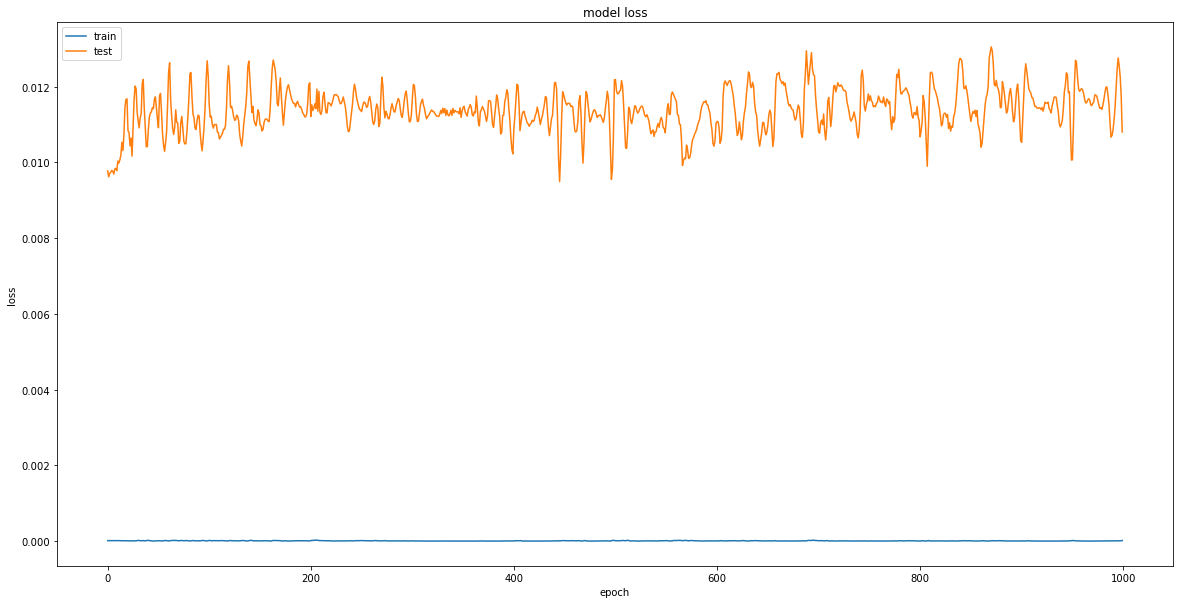

NameError: name 'fig' is not defined

In [149]:
from matplotlib import pyplot
# summarize history for loss
pyplot.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [137]:
model.evaluate(test_X, test_y, verbose=1)

14/14 [==============================] - 0s 3ms/step - loss: 5.0050e-06 - accuracy: 0.0000e+00


[5.005048478778917e-06, 0.0]

In [113]:
# make a prediction
yhat = model.predict(test_X)

In [114]:
#yhat = yhat.reshape(709,1)
feat_cols = -1 * (n_features - 1)

In [115]:
predict_X = test_X.reshape((test_X.shape[0], n_steps*n_features))

In [116]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, predict_X[:, feat_cols:]),axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [117]:
from math import sqrt
# invert scaling for actual
actual_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((actual_y, predict_X[:, feat_cols:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 5157.902


<AxesSubplot:>

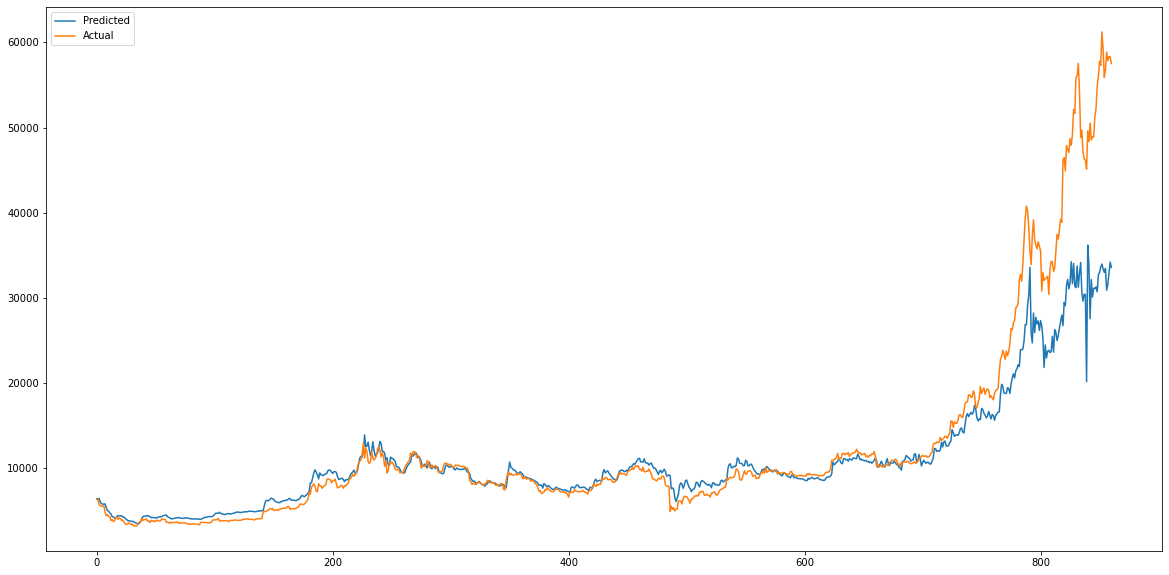

In [123]:
results = {'Predicted':inv_yhat ,'Actual':inv_y}
df_results = pd.DataFrame(results)
df_results.plot(figsize=(20,10))

In [121]:
from sklearn.metrics import r2_score
r2_score(inv_y, inv_yhat)

0.7906666841173067

In [105]:
df_results.head()

,Predicted,Actual
0,6648.622559,6371.270020
1,6653.564453,6359.490234
2,6652.153809,5738.350098
3,6450.468262,5648.029785
4,6287.454102,5575.549805


In [106]:
df_results.tail()

,Predicted,Actual
856,46098.183594,58870.890625
857,46624.218750,57858.921875
858,42595.824219,58346.648438
859,46687.855469,58313.640625
860,47971.226562,57523.421875


## Prep Technical Indicators

In [19]:
#Set Time Parameters for Windows

# Set the short window and long windows
short_window = 14
long_window = 28

# Set bollinger band window
bollinger_window = 14

#Standard Deviation
std_dev = 2

In [20]:
#Create Signals df via Copy
signals_df = btc_master_df.copy()

# Generate the "Close" short and long moving averages (50 and 100 days, respectively)
#Closing Price
signals_df["SMA50_close"] = signals_df["Close"].rolling(window = short_window).mean()
signals_df["SMA100_close"] = signals_df["Close"].rolling(window = long_window).mean()
#Supply Ratio
signals_df["SMA50_supply"] = signals_df["Supply Ratio"].rolling(window = short_window).mean()
signals_df["SMA100_suppy"] = signals_df["Supply Ratio"].rolling(window = long_window).mean()

# Add Bolinger Bands features with std of 2

# Calculate rolling mean and standard deviation
#Closing Price
signals_df['bollinger_mid_band_close'] = signals_df['Close'].rolling(window = bollinger_window).mean()
signals_df['bollinger_std_close'] = signals_df['Close'].rolling(window = bollinger_window).std()
#Supply Ratio
signals_df['bollinger_mid_band_supply'] = signals_df['Supply Ratio'].rolling(window = bollinger_window).mean()
signals_df['bollinger_std_supply'] = signals_df['Supply Ratio'].rolling(window = bollinger_window).std()

# Calculate upper and lowers bands of bollinger band
#Closing Price
signals_df['bollinger_upper_band_close']  = signals_df['bollinger_mid_band_close'] + (signals_df['bollinger_std_close'] * std_dev)
signals_df['bollinger_lower_band_close']  = signals_df['bollinger_mid_band_close'] - (signals_df['bollinger_std_close'] * std_dev)
#Supply Ratio
signals_df['bollinger_upper_band_close']  = signals_df['bollinger_mid_band_close'] + (signals_df['bollinger_std_close'] * std_dev)
signals_df['bollinger_lower_band_close']  = signals_df['bollinger_mid_band_close'] - (signals_df['bollinger_std_close'] * std_dev)

signals_df.head()

,Open,High,Low,Close,Adj Close,Volume,Circulating Supply,Max Supply,Supply Ratio,Volume Supply Ratio,Volume Close Ratio,nupl_ratio,mvrv_ratio,SMA50_close,SMA100_close,SMA50_supply,SMA100_suppy,bollinger_mid_band_close,bollinger_std_close,bollinger_mid_band_supply,bollinger_std_supply,bollinger_upper_band_close,bollinger_lower_band_close
Date,,,,,,,,,,,,,,,,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0,13280850.0,21000000.0,63.242143,1.585501,46042.496970,0.215017,0.446781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0,13280850.0,21000000.0,63.242143,2.596460,81243.991701,0.170461,0.330261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0,13280850.0,21000000.0,63.242143,2.855216,96048.847913,0.110795,0.196148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0,13292775.0,21000000.0,63.298929,2.773206,90152.213530,0.143593,0.275693,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0,13292775.0,21000000.0,63.298929,1.999590,66646.688783,0.122571,0.222286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
#Closing Price
signals_df['fast_close'] = signals_df['Close'].ewm(halflife=short_window).mean()
signals_df['slow_close'] = signals_df['Close'].ewm(halflife=long_window).mean()
#Supply Ratio
signals_df['fast_supply'] = signals_df['Supply Ratio'].ewm(halflife=short_window).mean()
signals_df['slow_supply'] = signals_df['Supply Ratio'].ewm(halflife=long_window).mean()

# Construct a crossover trading signal
#Closing Price
signals_df['crossover_long_close'] = np.where(signals_df['fast_close'] > signals_df['slow_close'], 1.0, 0.0)
signals_df['crossover_short_close'] = np.where(signals_df['fast_close'] < signals_df['slow_close'], -1.0, 0.0)
signals_df['crossover_signal_close'] = signals_df['crossover_long_close'] + signals_df['crossover_short_close']
#Supply Ratio
signals_df['crossover_long_supply'] = np.where(signals_df['fast_supply'] > signals_df['slow_supply'], 1.0, 0.0)
signals_df['crossover_short_supply'] = np.where(signals_df['fast_supply'] < signals_df['slow_supply'], -1.0, 0.0)
signals_df['crossover_signal_supply'] = signals_df['crossover_long_supply'] + signals_df['crossover_short_supply']

signals_df.head()

,Open,High,Low,Close,Adj Close,Volume,Circulating Supply,Max Supply,Supply Ratio,Volume Supply Ratio,Volume Close Ratio,nupl_ratio,mvrv_ratio,SMA50_close,SMA100_close,SMA50_supply,SMA100_suppy,bollinger_mid_band_close,bollinger_std_close,bollinger_mid_band_supply,bollinger_std_supply,bollinger_upper_band_close,bollinger_lower_band_close,fast_close,slow_close,fast_supply,slow_supply,crossover_long_close,crossover_short_close,crossover_signal_close,crossover_long_supply,crossover_short_supply,crossover_signal_supply
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0,13280850.0,21000000.0,63.242143,1.585501,46042.496970,0.215017,0.446781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,457.334015,457.334015,63.242143,63.242143,0.0,0.0,0.0,0.0,0.0,0.0
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0,13280850.0,21000000.0,63.242143,2.596460,81243.991701,0.170461,0.330261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,440.479942,440.683444,63.242143,63.242143,0.0,-1.0,-1.0,0.0,0.0,0.0
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0,13280850.0,21000000.0,63.242143,2.855216,96048.847913,0.110795,0.196148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,424.492103,425.007451,63.242143,63.242143,0.0,-1.0,-1.0,0.0,0.0,0.0
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0,13292775.0,21000000.0,63.298929,2.773206,90152.213530,0.143593,0.275693,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,420.301065,420.830884,63.257410,63.256871,0.0,-1.0,-1.0,1.0,0.0,1.0
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0,13292775.0,21000000.0,63.298929,1.999590,66646.688783,0.122571,0.222286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,415.569492,416.208314,63.266556,63.265704,0.0,-1.0,-1.0,1.0,0.0,1.0


In [27]:
#On-Chain Technical Signals (NUPL & MVRV)
def get_signal_mvrv(mvrv_value): 
    # returns the signal based one: 
    # if > 7 return -1
    # if < 0 return 1
    # else return 0
    # mvrv is a float
    signal=0
    if mvrv_value>7: 
        signal=-1
    elif mvrv_value<0: 
        signal=1
    return signal
signals_df['mvrv_signal'] = signals_df['mvrv_ratio'].map(get_signal_mvrv)

def get_signal_nupl(nupl_value): 
    # returns the signal based one: 
    # if > .75 return -1
    # if < 0 return 1
    # else return 0
    # mvrv is a float
    signal=0
    if nupl_value>.75: 
        signal=-1
    elif nupl_value<0: 
        signal=1
    return signal
signals_df['nupl_signal'] = signals_df['nupl_ratio'].map(get_signal_nupl)

signals_df.head()

,Open,High,Low,Close,Adj Close,Volume,Circulating Supply,Max Supply,Supply Ratio,Volume Supply Ratio,Volume Close Ratio,nupl_ratio,mvrv_ratio,SMA50_close,SMA100_close,SMA50_supply,SMA100_suppy,bollinger_mid_band_close,bollinger_std_close,bollinger_mid_band_supply,bollinger_std_supply,bollinger_upper_band_close,bollinger_lower_band_close,fast_close,slow_close,fast_supply,slow_supply,crossover_long_close,crossover_short_close,crossover_signal_close,crossover_long_supply,crossover_short_supply,crossover_signal_supply,mvrv_signal,nupl_signal
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0,13280850.0,21000000.0,63.242143,1.585501,46042.496970,0.215017,0.446781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,457.334015,457.334015,63.242143,63.242143,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0,13280850.0,21000000.0,63.242143,2.596460,81243.991701,0.170461,0.330261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,440.479942,440.683444,63.242143,63.242143,0.0,-1.0,-1.0,0.0,0.0,0.0,0,0
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0,13280850.0,21000000.0,63.242143,2.855216,96048.847913,0.110795,0.196148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,424.492103,425.007451,63.242143,63.242143,0.0,-1.0,-1.0,0.0,0.0,0.0,0,0
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0,13292775.0,21000000.0,63.298929,2.773206,90152.213530,0.143593,0.275693,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,420.301065,420.830884,63.257410,63.256871,0.0,-1.0,-1.0,1.0,0.0,1.0,0,0
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0,13292775.0,21000000.0,63.298929,1.999590,66646.688783,0.122571,0.222286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,415.569492,416.208314,63.266556,63.265704,0.0,-1.0,-1.0,1.0,0.0,1.0,0,0


In [28]:
csv_path = Path('../crypto_bot_project_2/Data/BTC_Signals.csv')
signals_df.to_csv(csv_path)
